# Recommender system test

### Propósito de la prueba:
Probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado

### Resultado esperado: 
Dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento **product_page**), instancias de agregar artículos al carrito de compras (**product_cart**) y compras (**purchase**). En cada etapa del embudo **product_page → product_cart → purchase**, habrá al menos un 10% de aumento.

## Instrucciones para completar la tarea

- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

## Describir los objetivos del estudio

Comprobaremos si los usuarios mostraron una mejor conversión en vistas de la página del pruducto (product_page), instancias de agregar artículos al carrito de compras (product_card) y compras (purchase). En cada etapa del embudo product_page → product_card → purchase, habrá al menos un 10% de aumento.

In [52]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import re
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

## Exploración de datos

In [2]:
mkt_events = pd.read_csv('datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('datasets/final_ab_events_upd_us.csv')
ab_data = pd.read_csv('datasets/final_ab_participants_upd_us.csv')

datas = [mkt_events, users, events, ab_data]

for data in datas: 
    print('---')
    print(data.sample())
    print()

---
                       name regions    start_dt   finish_dt
12  Single's Day Gift Promo    APAC  2020-11-11  2020-11-12

---
               user_id  first_date region   device
7485  734955B863D4E190  2020-12-14     EU  Android

---
                user_id             event_dt event_name  details
24768  CF40916C791BBA18  2020-12-17 06:17:09   purchase     4.99

---
               user_id group            ab_test
5361  C7C4ECB8E1499529     A  interface_eu_test



## MKT events

In [3]:
mkt_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
mkt_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [5]:
mkt_events.describe()

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


In [6]:
# Convertimos columnas de fecha a datetime

date_cols = ['start_dt', 'finish_dt']
for date in date_cols: 
    mkt_events[date] = pd.to_datetime(mkt_events[date], errors = 'coerce')

mkt_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


In [7]:
# Buscamos duplicados

mkt_events.duplicated().sum()

np.int64(0)

In [8]:
# Convertimos categorías a columnas binarias

def normalize_region_name(name: str) -> str:
    """
    Normaliza el nombre de región:
    - lower()
    - quita corchetes
    - reemplaza espacios, puntos y comas por "_"
    - elimina dobles guiones bajos
    """
    name = name.lower()
    name = re.sub(r"[\[\]]", "", name)         # quita corchetes
    name = re.sub(r"[ ,.\-]+", "_", name)      # reemplaza separadores por "_"
    name = re.sub(r"_+", "_", name)            # colapsa guiones bajos
    return name.strip("_")                     # elimina guiones bajos extremos

def expand_regions(df, col="regions", sep=","):
    # Dividir en listas, manejando NaN
    regions = df[col].fillna("").apply(
        lambda x: [normalize_region_name(r.strip()) for r in str(x).split(sep) if r.strip()]
    )
    
    # Crear binarizador
    mlb = MultiLabelBinarizer()
    dummies = pd.DataFrame(
        mlb.fit_transform(regions),
        index=df.index,
        columns=mlb.classes_
    )
    
    # Unir al df original
    return df.join(dummies)

mkt_events = expand_regions(mkt_events)

In [9]:
mkt_events

,name,regions,start_dt,finish_dt,apac,cis,eu,n_america
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,0,0,1,1
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,1,1,1,1
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,0,0,1,1
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,1,1,1,1
4,4th of July Promo,N.America,2020-07-04,2020-07-11,0,0,0,1
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,1,1,1,1
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,1,0,0,0
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,1,1,1,0
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,1,1,1,0
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,0,1,0,0


## Users

In [10]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [12]:
users.duplicated().sum()

np.int64(0)

In [13]:
users.first_date = pd.to_datetime(users.first_date, errors = 'coerce')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [14]:
# Conteo por dispositivos
users.device.value_counts()

device
Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: count, dtype: int64

In [15]:
# Conteo por región
users.region.value_counts()

region
EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: count, dtype: int64

In [16]:
users.region = users.region.str.lower().str.replace('.','_')
users.region.unique()

array(['eu', 'n_america', 'apac', 'cis'], dtype=object)

In [17]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,eu,PC
1,F1C668619DFE6E65,2020-12-07,n_america,Android
2,2E1BF1D4C37EA01F,2020-12-07,eu,PC
3,50734A22C0C63768,2020-12-07,eu,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,n_america,iPhone


## User events

In [18]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [20]:
events.duplicated().sum()

np.int64(0)

In [21]:
# Comprobamos que los valores no nulos de details, pertenecen a eventos de tipo 'purchase'
len(events[events.event_name == 'purchase'])

60314

In [22]:
null_details = events[events.details.isnull()]
null_details.event_name.unique()


array(['product_cart', 'product_page', 'login'], dtype=object)

In [23]:
# Frecuencias por evento
events.event_name.value_counts()

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

In [24]:
# Convertimos columna event_dt a tipo datetime
events.event_dt = pd.to_datetime(events.event_dt, errors = 'coerce')
events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [25]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


## AB data

In [26]:
ab_data.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [27]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [28]:
ab_data.duplicated().sum()

np.int64(0)

In [29]:
ab_data.ab_test.value_counts()

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

In [30]:
# Seleccionaremos los usuarios que realizaron la prueba recommender_system_test
recomender_system = ab_data[ab_data.ab_test == 'recommender_system_test']
recomender_system.sample(5)

,user_id,group,ab_test
2664,E26CE7138789A7AF,B,recommender_system_test
28,76326F7A53D2008C,B,recommender_system_test
1387,2174C1A128A5B557,A,recommender_system_test
382,14E1DBBBC0CCBA6D,A,recommender_system_test
2065,9EC7E3150902029D,A,recommender_system_test


In [31]:
recomender_system.group.value_counts()

group
A    2747
B     928
Name: count, dtype: int64

In [32]:
#Checamos si un usuario pertenece a los dos grupos
recomender_system.groupby("user_id")["group"].nunique().gt(1).any()
# True si hay al menos un usuario en más de un grupo


np.False_

En general no encontramos problemas con la exploración de datos. Sí tuvimos que convertir algunas columnas, las que son de fecha a datetime, pero fueron las únicas.

Tampoco encontramos valores nulos, repetios, o usuarios que fueran parte de los dos grupos.

## Llevar a cabo el análisis exploratorio de datos:    
- Estudia la conversión en las diferentes etapas del embudo.
- ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
- ¿Hay usuarios que están presentes en ambas muestras?
- ¿Cómo se distribuye el número de eventos entre los días?
- ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [33]:
# Haremos un merge con nuestra tablas para tener todo en un mismo data frame

users_part = users.merge(
    recomender_system[['user_id', 'group']],
    on = 'user_id',
    how = 'inner'
)

# Ahora hacemos merge con events
events_full = events.merge(
    users_part[['user_id', 'first_date', 'group']],
    on = 'user_id', 
    how = 'inner'
)

events_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23909 entries, 0 to 23908
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23909 non-null  object        
 1   event_dt    23909 non-null  datetime64[ns]
 2   event_name  23909 non-null  object        
 3   details     3210 non-null   float64       
 4   first_date  23909 non-null  datetime64[ns]
 5   group       23909 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 1.1+ MB


In [34]:
# Filtraremos a los usuarios que tuvieron eventos 14 días despúes de la first_date de eventos
# creamos máscara
mask = (
    (events_full['event_dt'] >= events_full.first_date) & 
    (events_full.event_dt <= events_full.first_date + pd.Timedelta(days=14))
)
#aplicamos filtro
events_window = events_full[mask].copy()
events_window.head()

print("Eventos antes del filtro:", events_full.shape[0])
print("Eventos después del filtro:", events_window.shape[0])

Eventos antes del filtro: 23909
Eventos después del filtro: 23151


In [35]:
# Queremos verificar que todos los usuarios hayan hecho login
# Contamos cuántos usuarios únicos tenemos
events_window.user_id.nunique()

3675

In [36]:
# Vemos cuántos usuarios únicos hicieron el evento login
events_window.groupby('event_name')['user_id'].nunique()

event_name
login           3674
product_cart    1079
product_page    2303
purchase        1128
Name: user_id, dtype: int64

In [37]:
# Construiremos un embudo de las etapas para realizar la conversión en cada etapa

# 1) Pivot table: contar eventos por usuario y tipo
user_event_counts = events_window.groupby(['user_id','event_name']).size().unstack(fill_value=0)

# 2) Crear flags 0/1 para cada etapa del embudo
has_page = (user_event_counts.get('product_page', 0) > 0).astype(int).rename('has_product_page')
has_cart = (user_event_counts.get('product_cart', 0) > 0).astype(int).rename('has_product_cart')
has_purchase = (user_event_counts.get('purchase', 0) > 0).astype(int).rename('has_purchase')

# 3) Unir flags en un solo DataFrame
flags = pd.concat([has_page, has_cart, has_purchase], axis=1).reset_index()

# 4) Unir con info de usuario (grupo y first_date)
users_part = users.merge(recomender_system[['user_id','group']], on='user_id', how='inner')
df_funnel = users_part.merge(flags, on='user_id', how='left').fillna(0)

# Asegurarnos de que los flags sean enteros
for c in ['has_product_page','has_product_cart','has_purchase']:
    df_funnel[c] = df_funnel[c].astype(int)

# 5) Ver primeras filas
print(df_funnel.head())


            user_id first_date region   device group  has_product_page  \
0  D72A72121175D8BE 2020-12-07     eu       PC     A                 1   
1  DD4352CDCF8C3D57 2020-12-07     eu  Android     B                 1   
2  831887FE7F2D6CBA 2020-12-07     eu  Android     A                 0   
3  4CB179C7F847320B 2020-12-07     eu   iPhone     B                 1   
4  29C92313A98B1176 2020-12-07   apac  Android     B                 1   

   has_product_cart  has_purchase  
0                 0             0  
1                 0             0  
2                 1             1  
3                 0             0  
4                 0             0  


In [38]:
# Calcular la conversión abslouta por grupo

funnel_summary = (
    df_funnel.groupby("group")[["has_product_page","has_product_cart","has_purchase"]]
    .mean()  # promedio de 0/1 = porcentaje de usuarios
    .mul(100)  # pasamos a %
    .round(2)
)
print(funnel_summary)


       has_product_page  has_product_cart  has_purchase
group                                                  
A                 64.80             30.00         31.74
B                 56.36             27.48         27.59


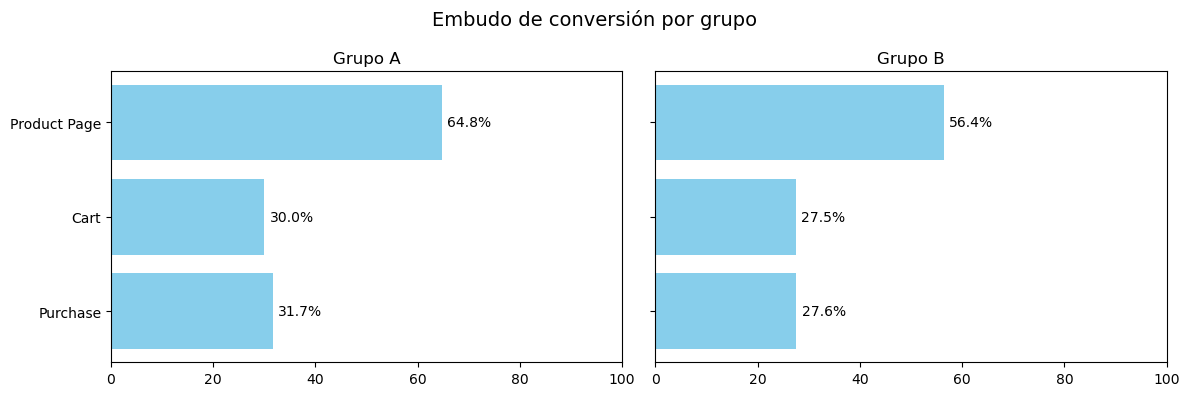

In [39]:
# Graficamos evolución de cada grupo

# etapas en orden
stages = ["has_purchase", "has_product_cart", "has_product_page"]
stage_labels = ["Purchase", "Cart", "Product Page"]

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, group in zip(axes, funnel_summary.index):
    values = funnel_summary.loc[group, stages]
    ax.barh(stage_labels, values, color="skyblue")
    ax.set_xlim(0, 100)
    ax.set_title(f"Grupo {group}")
    # anotar porcentajes
    for i, v in enumerate(values):
        ax.text(v + 1, i, f"{v:.1f}%", va="center")

fig.suptitle("Embudo de conversión por grupo", fontsize=14)
plt.tight_layout()
plt.show()


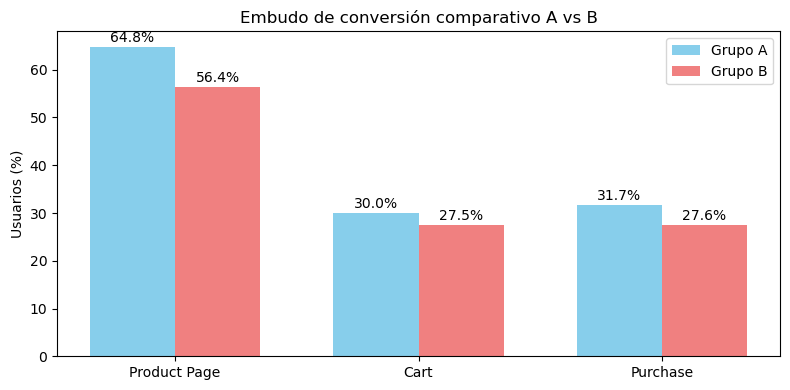

In [40]:
# Graficamos embudo comparando los grupos
# etapas en orden
stages = ["has_product_page", "has_product_cart", "has_purchase"]
stage_labels = ["Product Page", "Cart", "Purchase"]

# posiciones para las barras
x = np.arange(len(stages))  # 0,1,2
width = 0.35  # ancho de cada barra

fig, ax = plt.subplots(figsize=(8,4))

# barras para cada grupo
ax.bar(x - width/2, funnel_summary.loc["A", stages], width, label="Grupo A", color="skyblue")
ax.bar(x + width/2, funnel_summary.loc["B", stages], width, label="Grupo B", color="lightcoral")

# detalles
ax.set_xticks(x)
ax.set_xticklabels(stage_labels)
ax.set_ylabel("Usuarios (%)")
ax.set_title("Embudo de conversión comparativo A vs B")
ax.legend()
v
# anotar valores encima
for i, stage in enumerate(stages):
    ax.text(i - width/2, funnel_summary.loc["A", stage] + 1, 
            f"{funnel_summary.loc['A', stage]:.1f}%", ha="center", color="black")
    ax.text(i + width/2, funnel_summary.loc["B", stage] + 1, 
            f"{funnel_summary.loc['B', stage]:.1f}%", ha="center", color="black")

plt.tight_layout()
plt.show()



Grupo B rinde peor que A en todas las etapas, y muy lejos del +10% esperado.

También notamos que los porcentajes de Purchase con mayores que Cart. 

In [41]:
# Calcular conversión condicional

conversion_conditional = (
    df_funnel.groupby("group")[["has_product_page","has_product_cart","has_purchase"]]
    .apply(lambda g: pd.Series({
        "page→cart %": (g["has_product_cart"].sum() / g["has_product_page"].sum() * 100).round(2),
        "cart→purchase %": (g["has_purchase"].sum() / g["has_product_cart"].sum() * 100).round(2),
    }))
)
print(conversion_conditional)


       page→cart %  cart→purchase %
group                              
A            46.29           105.83
B            48.76           100.39


Se detecta que el número de usuarios con purchase supera al de product_cart. 

Esto sugiere que el evento product_cart no siempre se registra antes de la compra (quizá por un flujo alternativo de ‘compra directa’ o por pérdidas en el log). Esta limitación debe considerarse al interpretar las tasas de conversión.

In [42]:
# Verificamos cuánto porcentaje de usuarios para a Purchase sin pasar por Cart

users_with_cart = set(df_funnel.loc[df_funnel["has_product_cart"] == 1, "user_id"])
users_with_purchase = set(df_funnel.loc[df_funnel["has_purchase"] == 1, "user_id"])

purchase_without_cart = users_with_purchase - users_with_cart
print(f"Usuarios con purchase pero sin cart: {len(purchase_without_cart)}")

perc_purchase_without_cart = len(purchase_without_cart) / len(users_with_purchase) * 100
print(f"Porcentaje de compradores sin cart: {perc_purchase_without_cart:.2f}%")



Usuarios con purchase pero sin cart: 783
Porcentaje de compradores sin cart: 69.41%


Tenemos un gran porcentaje de usuarios que pasaron a Purchase sin pasar por el evento Cart. 69.41%

In [43]:
# Análizamos el comportamiento de estos usuarios

# tomamos 3 usuarios de ejemplo que tienen purchase pero no cart
sample_users = list(purchase_without_cart)[:3]

# vemos todos sus eventos ordenados
sample_flows = (
    events[events["user_id"].isin(sample_users)]
    .sort_values(["user_id","event_dt"])
)

print(sample_flows[["user_id","event_dt","event_name"]].head(30))


                 user_id            event_dt    event_name
16422   37E78FED858E7061 2020-12-14 11:14:34      purchase
153402  37E78FED858E7061 2020-12-14 11:14:34  product_page
291053  37E78FED858E7061 2020-12-14 11:14:34         login
22414   37E78FED858E7061 2020-12-16 14:07:31      purchase
309100  37E78FED858E7061 2020-12-16 14:07:31         login
165393  37E78FED858E7061 2020-12-16 14:07:32  product_page
14831   84F840D269A65875 2020-12-14 12:02:53      purchase
286253  84F840D269A65875 2020-12-14 12:02:53         login
18577   84F840D269A65875 2020-12-15 15:17:06      purchase
297394  84F840D269A65875 2020-12-15 15:17:06         login
24866   84F840D269A65875 2020-12-17 20:27:25      purchase
316371  84F840D269A65875 2020-12-17 20:27:25         login
34189   8693A09149596719 2020-12-19 01:49:29      purchase
344831  8693A09149596719 2020-12-19 01:49:29         login
36607   8693A09149596719 2020-12-20 07:25:15      purchase
352192  8693A09149596719 2020-12-20 07:25:15         log

In [44]:
dup_events = (
    events.groupby(["user_id", "event_dt"])["event_name"]
    .nunique()
    .reset_index()
)

same_time = dup_events[dup_events["event_name"] > 1]
print(f"Eventos con más de un tipo en el mismo segundo: {len(same_time)}")


Eventos con más de un tipo en el mismo segundo: 112588


**Anomalías que vemos:**
- Eventos como purchase y login exactamente en el mismo segundo.
- Secuencias ilógicas: purchase antes de product_page, o sin cart.

**Posibles causas**
- Algunos sistemas mandan eventos en paquetes, y al guardarse reciben la misma marca de tiempo, eso hace que parezca que todo pasó a la vez.
- Si el timestamp es de “servidor que recibe”, puede no respetar el orden exacto de lo que hizo el usuario.
- Puede que purchase se dispare automáticamente cuando se completa una transacción, y el sistema envía un login de confirmación en paralelo.

#### Para interpretar la prueba A/B, debemos centrarnos en conversiones absolutas de purchase y product_page

In [45]:
# calcular porcentaje de usuarios que vieron product_page o hicieron purchase
conversion_absoluta = (
    df_funnel.groupby("group")[["has_product_page","has_purchase"]]
    .mean()  # promedio de 0/1 = porcentaje de usuarios
    .mul(100)  # pasar a %
    .round(2)
)
print(conversion_absoluta)


       has_product_page  has_purchase
group                                
A                 64.80         31.74
B                 56.36         27.59


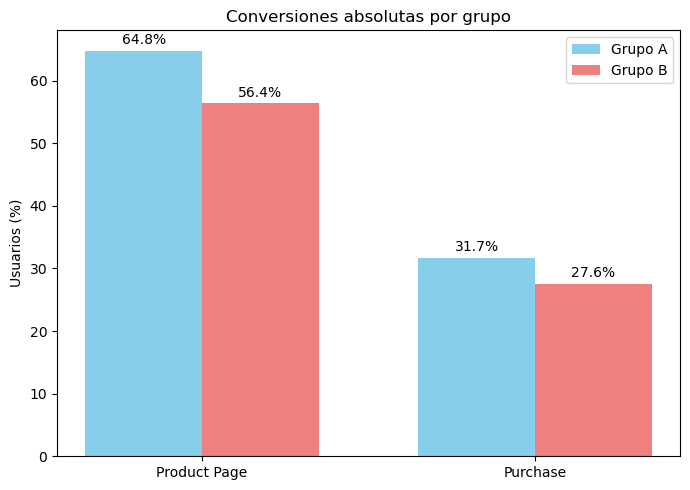

In [46]:
# Graficamos conversion_absoluta ya calculada

# etiquetas y posiciones
stages = ["has_product_page", "has_purchase"]
stage_labels = ["Product Page", "Purchase"]
x = np.arange(len(stages))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

# barras por grupo
ax.bar(x - width/2, conversion_absoluta.loc["A", stages], width, label="Grupo A", color="skyblue")
ax.bar(x + width/2, conversion_absoluta.loc["B", stages], width, label="Grupo B", color="lightcoral")

# detalles
ax.set_xticks(x)
ax.set_xticklabels(stage_labels)
ax.set_ylabel("Usuarios (%)")
ax.set_title("Conversiones absolutas por grupo")
ax.legend()

# anotar valores encima de cada barra
for i, stage in enumerate(stages):
    ax.text(i - width/2, conversion_absoluta.loc["A", stage] + 1, f"{conversion_absoluta.loc['A', stage]:.1f}%", ha="center")
    ax.text(i + width/2, conversion_absoluta.loc["B", stage] + 1, f"{conversion_absoluta.loc['B', stage]:.1f}%", ha="center")

plt.tight_layout()
plt.show()

El gráfico permite ver de un vistazo que B no alcanzó la mejora esperada, y que el embudo real se basa solo en estas dos etapas.

### Distribución de eventos por usuario

In [47]:
# Contamos los eventos por usuario

events_per_user = events_window.groupby(['user_id', 'group'])['event_name'].count().reset_index()
events_per_user.rename(columns = {'event_name': 'num_events'}, inplace = True)
events_per_user.head()

,user_id,group,num_events
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


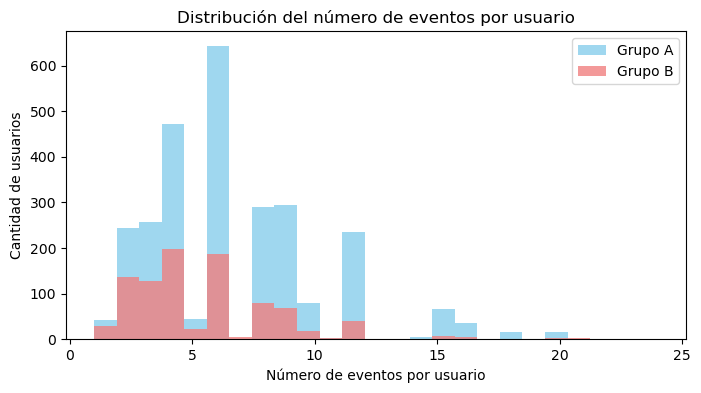

In [48]:
plt.figure(figsize=(8,4))
plt.hist(events_per_user[events_per_user.group=="A"]["num_events"], bins=25, alpha=0.8, label="Grupo A", color="skyblue")
plt.hist(events_per_user[events_per_user.group=="B"]["num_events"], bins=25, alpha=0.8, label="Grupo B", color="lightcoral")
plt.xlabel("Número de eventos por usuario")
plt.ylabel("Cantidad de usuarios")
plt.title("Distribución del número de eventos por usuario")
plt.legend()
plt.show()


<Figure size 600x400 with 0 Axes>

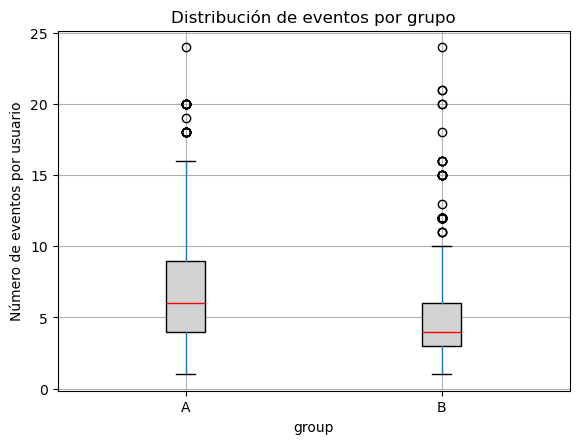

In [49]:
plt.figure(figsize=(6,4))
events_per_user.boxplot(column="num_events", by="group", grid=True, patch_artist=True,
                        boxprops=dict(facecolor='lightgray'), medianprops=dict(color='red'))
plt.ylabel("Número de eventos por usuario")
plt.title("Distribución de eventos por grupo")
plt.suptitle("")
plt.show()


- En una prueba A/B bien diseñada, la actividad de usuarios debería estar más o menos balanceada entre los grupos, ya que se espera que el split sea aleatorio.

- El hecho de que Grupo B sea más pequeño y además menos activo introduce un riesgo:

    - La diferencia que vemos en conversiones puede deberse al sesgo de actividad, no al cambio en el embudo de pago.

- Esto es una alerta sobre la validez de la prueba.

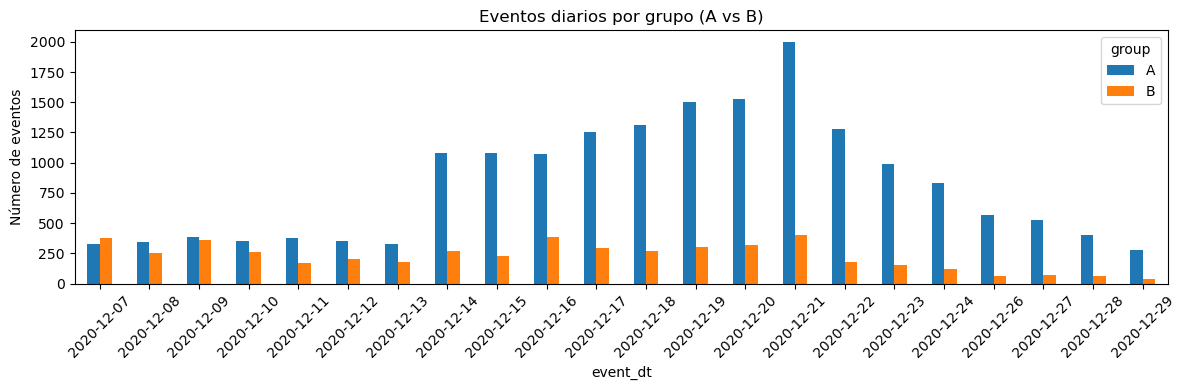

In [50]:
# Revisemos cuántos eventos hubo por grupo por día

events_per_day_group = (
    events_window.groupby([events_window["event_dt"].dt.date, "group"])
    .size()
    .unstack(fill_value=0)
)

events_per_day_group.plot(kind="bar", stacked=False, figsize=(12,4))
plt.ylabel("Número de eventos")
plt.title("Eventos diarios por grupo (A vs B)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Lo que vemos en la gráfica

##### Grupo A (control)
- Mucho más volumen de eventos (ya lo sabíamos, tiene más usuarios).
- Entre el 14 y el 20 de diciembre la actividad crece bastante, con un pico máximo el 20 de diciembre.
- Después del 24 empieza a estabilizarse o bajar un poco (coincide con vísperas de Navidad).

##### Grupo B (Experimento - Nuevo embudo de pago)
- Actividad mucho más baja en general (menos usuarios).
- Relativamente estable al inicio, sin el mismo crecimiento fuerte que A.
- A partir del 21 de diciembre cae, y ya no se recupera.

### Exploración de datos (EDA)
1. Conversión en las diferentes etapas del embudo
    - Se observa que hay más usuarios que hacen purchase que product_cart.
    - Esto indica que no todos los usuarios siguen el embudo esperado product_page → product_cart → purchase.
    - Por lo tanto, el análisis de conversiones condicionales no es fiable.
    - Nos centramos en conversiones absolutas:
        - Grupo A: ~64.8% ven producto, ~31.7% compran.
        - Grupo B: ~56.4% ven producto, ~27.6% compran.

        Conclusión: Grupo B no logró el +10% esperado en ninguna etapa.

2. ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - Grupo B tiene menos usuarios y menos eventos por usuario en promedio.
    - El boxplot mostró que el rango intercuartílico de B está por debajo del de A.
    - Ambos grupos tienen outliers (usuarios con muchos eventos).

        Conclusión: hay una desigualdad de actividad entre grupos, lo cual puede sesgar la prueba.

3. ¿Hay usuarios que están presentes en ambas muestras?
    - No.
    - Confirmamos que cada usuario pertenece a un único grupo (A o B).

        Conclusión: no hay contaminación entre grupos.

4. ¿Cómo se distribuye el número de eventos entre los días?
    - Grupo A crece en actividad entre el 14 y el 20 de diciembre, con un pico máximo el 20.
    - Grupo B se mantiene más estable al inicio, pero su actividad cae después del 21 de diciembre.
        Conclusión: hay peculiaridades temporales que pueden estar relacionadas con la finalización del reclutamiento de usuarios y con la temporada navideña.

5. ¿Hay alguna peculiaridad en los datos que considerar antes de la prueba A/B?
    -   Sí, varias:
        - Eventos simultáneos (purchase y login en el mismo segundo).
        - Saltos de embudo (compras sin carrito).
        - Grupo B más pequeño y menos activo.
        - Diferencias en la actividad diaria entre A y B.

    ➡️ Todo esto implica que la prueba no está perfectamente balanceada y sus resultados deben interpretarse con precaución.

In [ ]:
# --- Totales de usuarios en cada grupo ---
n_A = df_funnel[df_funnel.group=="A"].shape[0]
n_B = df_funnel[df_funnel.group=="B"].shape[0]

# --- Usuarios que llegaron a product_page ---
x_A_page = df_funnel[df_funnel.group=="A"]["has_product_page"].sum()
x_B_page = df_funnel[df_funnel.group=="B"]["has_product_page"].sum()

# --- Usuarios que hicieron purchase ---
x_A_purchase = df_funnel[df_funnel.group=="A"]["has_purchase"].sum()
x_B_purchase = df_funnel[df_funnel.group=="B"]["has_purchase"].sum()

print("Usuarios en grupo A:", n_A, " | product_page:", x_A_page, " | purchase:", x_A_purchase)
print("Usuarios en grupo B:", n_B, " | product_page:", x_B_page, " | purchase:", x_B_purchase)

# --- Prueba Z: Product Page ---
count_page = np.array([x_A_page, x_B_page])
nobs_page = np.array([n_A, n_B])
stat_page, pval_page = proportions_ztest(count_page, nobs_page)
print("\nProduct Page → z =", stat_page, "p-value =", pval_page)

# --- Prueba Z: Purchase ---
count_purchase = np.array([x_A_purchase, x_B_purchase])
nobs_purchase = np.array([n_A, n_B])
stat_purchase, pval_purchase = proportions_ztest(count_purchase, nobs_purchase)
print("\nPurchase → z =", stat_purchase, "p-value =", pval_purchase)


Usuarios en grupo A: 2747  | product_page: 1780  | purchase: 872
Usuarios en grupo B: 928  | product_page: 523  | purchase: 256

Product Page → z = 4.595797095745397 p-value = 4.310980554712425e-06

Purchase → z = 2.3740870442615747 p-value = 0.017592402663314678


# 📊 Informe de resultados – Prueba A/B  
**Nombre de la prueba:** `recommender_system_test`  
**Grupos:** A (control) vs B (nuevo embudo de pago)  
**Periodo:** 2020-12-07 → 2021-01-01  
**Objetivo esperado:** +10% en conversión en cada etapa del embudo (`product_page → product_cart → purchase`).  

---

## 🔍 1. Exploración de datos (EDA)

1. **Integridad de los datos**
   - No hay usuarios duplicados entre grupos (cada `user_id` pertenece a un solo grupo).  
   - Se detectaron comportamientos atípicos: usuarios con eventos de `purchase` sin haber registrado `product_cart`. (~70% de los compradores no pasaron por `cart`).

2. **Distribución de usuarios**
   - Grupo A: 2747 usuarios.  
   - Grupo B: 928 usuarios.  
   - El experimento no tuvo grupos balanceados: **A fue casi 3 veces mayor que B**.  

3. **Eventos en el tiempo**
   - Grupo A mostró un **aumento progresivo de eventos** entre el 14 y 20 de diciembre (pico el 20/12).  
   - Grupo B se mantuvo más estable y **cayó en actividad tras el 21 de diciembre** (fecha en que se dejó de aceptar nuevos usuarios).  
   - Esto introduce una **peculiaridad temporal** que pudo sesgar los resultados.  

---

## 🔍 2. Conversión en el embudo

- Conversión absoluta (usuarios que alcanzaron cada etapa):  

| Grupo | Product Page | Product Cart | Purchase |
|-------|--------------|--------------|----------|
| A     | 64.8%        | 30.0%        | 31.7%    |
| B     | 56.4%        | 27.5%        | 27.6%    |

- Conversión condicional (paso a paso en el funnel):  

| Grupo | Page → Cart | Cart → Purchase |
|-------|-------------|-----------------|
| A     | 46.3%       | 105.8%*         |
| B     | 48.8%       | 100.4%*         |

\* >100% porque muchos usuarios compraron sin pasar por `cart`.  

---

## 🔍 3. Prueba estadística (Z-test de proporciones)

- **Product Page:**  
  - A: 1780/2747 (64.8%) vs B: 523/928 (56.4%).  
  - z = 4.60, p ≈ 0.000004 → diferencia significativa.  

- **Purchase:**  
  - A: 872/2747 (31.7%) vs B: 256/928 (27.6%).  
  - z = 2.37, p ≈ 0.018 → diferencia significativa.  

---

## ✅ Conclusiones

1. **No se alcanzó el objetivo de negocio** (+10% de mejora en cada etapa del funnel).  
   - El grupo B tuvo menor conversión absoluta en todas las etapas frente a A.  

2. **Las diferencias entre A y B son estadísticamente significativas**, pero en dirección negativa: **B rinde peor que A**.  

3. **Peculiaridades en los datos**:
   - Muchos usuarios registran `purchase` sin `cart`, lo cual distorsiona el embudo.  
   - El grupo B tuvo menos usuarios y menor actividad tras el 21/12, lo que puede afectar la validez de la comparación.  

---

## 📌 Recomendación
- No implementar el nuevo embudo de pago (grupo B) en producción, ya que no mejora la conversión y, de hecho, la reduce.  
- Revisar el **tracking de eventos**, especialmente `product_cart`, para asegurar consistencia en futuros experimentos.  
- Planear futuros A/B tests con **grupos balanceados en tamaño** y **períodos de exposición equivalentes** para evitar sesgos temporales.  
